## Value Added by Employee as a Trading Signal
By John Loeber

Notebook released under the Creative Commons Attribution 4.0 License.

---

### Abstract

We attempt to define a metric for how efficiently companies use their employees, and investigate whether we can use this metric as a trading signal.



### Introduction

Facebook currently has 10,082 employees with a \$245 billion market cap. Dividing the market cap by the employee count, we get a valuation of about \$24 million per employee. While this is a crude-at-best representation of the average value added by an employee, it intuitively indicates two things:
1. Facebook has many highly valuable employees
2. Facebook is an efficiently run business.

A company with many talented employees should find it comparatively easier to create value, and a business being efficiently run means that it has minimal bloat and should therefore be more nimble in response to changing markets. Thus, I conjecture that in the long run, **companies that score high by some measure of *value added by employee* ($V$) should outperform other companies**.

### Defining Metrics

We want to investigate if some representation of $V$ is viable as a trading signal. Before we do that, we have to come up with a metric for $V$. The ratio $\frac{\text{Market Cap}}{\text{Employee Count}} = V$ is too crude for many obvious reasons, the most critical of which is perhaps that overvalued companies would score very well by this metric. What we really want is a metric along the following lines:

$$
\frac{\text{Total Value Generated By Employees - (Total Operational Expenses)}}{\text{Employee Count}}
$$

There are (in my opinion) at least two measurements available in the [Quantopian Fundamental Dataset](https://www.quantopian.com/help/fundamentals) that make appropriate numerators in that ratio: `ebitda` and `net_income`. We use `total_employee_number`, also from the Fundamental Dataset, as the denominator. Let $\frac{\texttt{ebitda}}{\texttt{total_employee_number}} = V_1$ and $\frac{\texttt{net_income}}{\texttt{total_employee_number}} = V_2$. We'll investigate both $V_1$ and $V_2$ as potential trading signals.

### Conditions

How do we evaluate $V_1$ and $V_2$ as trading signals? First, we have to note that a comparatively high or low score will differ by industry: consider a company in the construction sector that has hired many employees to carry out manual labor. Even if it runs as efficiently as possible, it may still not score as well in terms of $V_1$ or $V_2$ as an inefficiently run software company, simply because it requires far more employees to contribute equivalent financial value. So we will want to consider $V_1$ and $V_2$ by sector. 

We will also want to not consider companies that don't meet some threshold for size: presumably, as either numerator or denominator of $V_1$ or $V_2$ become very small, we'll have much noisier data. For the purposes of this investigation, we require that a company has at least:
1. 50 employees
2. \$20m in ebitda
3. \$10m in net income

Note that these criteria automatically exclude certain growth-investment companies that are at a particular stage in their development (e.g. Tesla Motors would, as of present, not be able to meet either ebitda or net income requirements). 

### Buy and Sell Signals

Now let's think about $V_1$ and $V_2$ as *sell signals*: they're not very good. The primary problem is that the `total_employee_number` is only reliably updated once a year in a company's annual report. While it would be possible to conjure some related sell signals, for the purpose of keeping this investigation simple We will consider $V_1$ and $V_2$ only as a buy signal. As we are not considering any sell signals, we will use a simple buy-and-hold strategy: if the buy signal is triggered, then we purchase the asset, hold it for a year, and then sell.

We choose the holding period of a year since:
1. The `total_employee_number` is only reliably updated once a year
2. If the thesis -- that more employee-efficient companies outperform other companies -- is true, then a year should be enough time for that effect to be notable. (Note: this is an untested assumption.)

### Testing

When do we consider $V_1$ or $V_2$ to be a buy-signal? Let's find out! 

We restrict the following investigation, without loss of generality, to the technology sector. Equivalent investigations can be made for other sectors. We will consider every calendar year as a time period, determine a company's $V_1$ and $V_2$ at the start of the period, and find their percentage price change over the period. While this does not exactly replicate the strategy outlined above (hold until annual report is released), it should be good enough.

Note: in my investigation, I did not factor dividends paid into the percentage price change statistic. (Considering the results obtained, it is unlikely that factoring in dividends paid would have made a significant difference.)

In [21]:
# importing the libraries we will need from this point onwards
import datetime
from math import isnan
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import numpy as np
import zipline

# initialize fundamentals in the notebook
fundamentals = init_fundamentals()

In [22]:
# define our time periods. start date for the data: january 3 2002. in datetime format, '2002-01-03'
dates = ['2002-01-03', '2003-01-04', '2004-01-05', '2005-01-06', '2006-01-07', '2007-01-08', '2008-01-09', 
         '2009-01-10', '2010-01-11', '2011-01-12', '2012-01-13', '2013-01-14', '2014-01-15']

# note on time periods: every time period is 366 days, rather than the usual 365. 
# While this shouldn't make a difference in practice, it may seem odd. We use 366 instead of 365
# because in a previous version of this project, it was necessary to use 366 for a technical reason.
# This technical reason is no longer relevant to this version of the project, so using 366 instead of 365
# is simply a technical relic. For practical intents, it doesn't make a difference, and it would be tedious
# to update everything appropriately.

years = range(2002,2015)

# we create a dictionary that maps every year in the time period to a pandas dataframe of the
# equities under consideration for that year
tablesPerYear = {}

for i in range(13):
    # we query the fundamentals dataset to get equities fitting our criteria
    tablesPerYear[years[i]] = get_fundamentals(query(fundamentals.income_statement.ebitda,
                             fundamentals.income_statement.net_income,
                             fundamentals.general_profile.total_employee_number)
                            .filter(fundamentals.asset_classification.morningstar_sector_code == 311)
                            .filter(fundamentals.general_profile.total_employee_number > 50)
                            .filter(fundamentals.income_statement.ebitda > 20000000)
                            .filter(fundamentals.income_statement.net_income > 10000000)
                           , dates[i])
    
# Morningstar sector codes pulled from: https://www.equitieslab.com/wiki/admin/morningstar-sector. 
# Technology is code 311.

# Could also do this with industry code instead of sector code, WLOG. 
# That might yield more precision, which would be good.

In [23]:
def addAYear(s):
    """ takes a date in string format and adds exactly 366 days to it"""
    end = datetime.datetime.strptime(s,'%Y-%m-%d') + datetime.timedelta(days=366)
    return end.strftime('%Y-%m-%d')

In [24]:
# probably using pandas pretty inefficiently here. New to it. Could refactor later.

# create a dictionary that maps every year to a list of relevant datapoints,
# where the form of a datapoint is (v1 score, v2 score, % price change, stock id number)
dataPointsByYear = {}

for i in range(13):
    # make a list of datapoints for that year
    annualData = []
    year = years[i]
    
    # Making tuples of (Column Data, SID). The pandas dataframe of tablesPerYear is organized by columns.
    StockData = [(tablesPerYear[year][stock], stock.sid) for stock in tablesPerYear[year]]

    for (column,sid) in StockData:
        # grab the ebitda, net, employees data and compute our metrics
        ebitda, net, employees = [x for x in column]
        v1 = ebitda / employees
        v2 = net / employees
        startDate = dates[i]
        endDate = addAYear(startDate)
        # have to grab prices to get the percentage change between start and end
        prices = get_pricing([sid], 
                             start_date = startDate, 
                             end_date = endDate, 
                             fields ='close_price',
                            frequency = 'daily')
        purePrices = [val for val in prices[sid]]
        startPrice = purePrices[0]
        endPrice = purePrices[-1]
        percentChange = ((endPrice - startPrice)/startPrice) * 100
        if isnan(percentChange):
            # getting some strange NaN errors for sids 4400 and 8289. Going to just skip those.
            continue
        else:
            returnTuple = (v1,v2,percentChange,sid)
            annualData.append(returnTuple)
    
    # map that year to the list of datapoints we collected just above.
    dataPointsByYear[year] = annualData

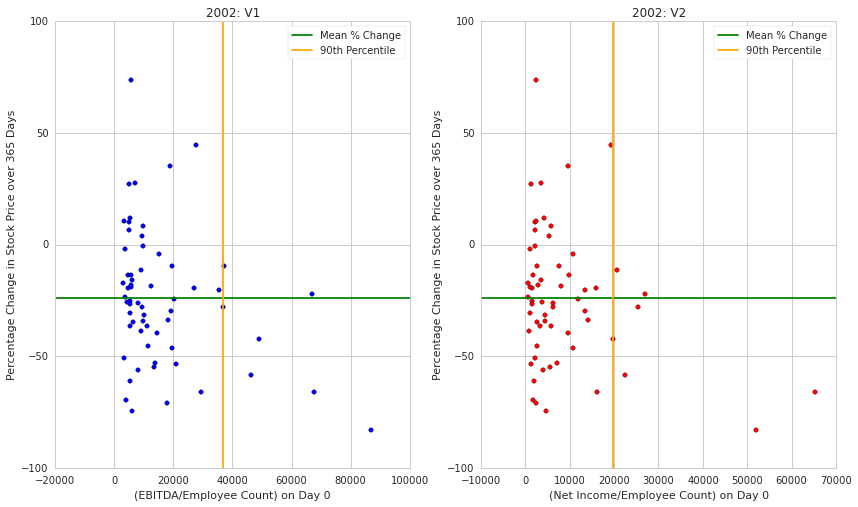

V1 Correlation:  (-0.30185122747936766, 0.017110928864449402)
V2 Correlation:  (-0.27078426125696037, 0.033278175091550247)


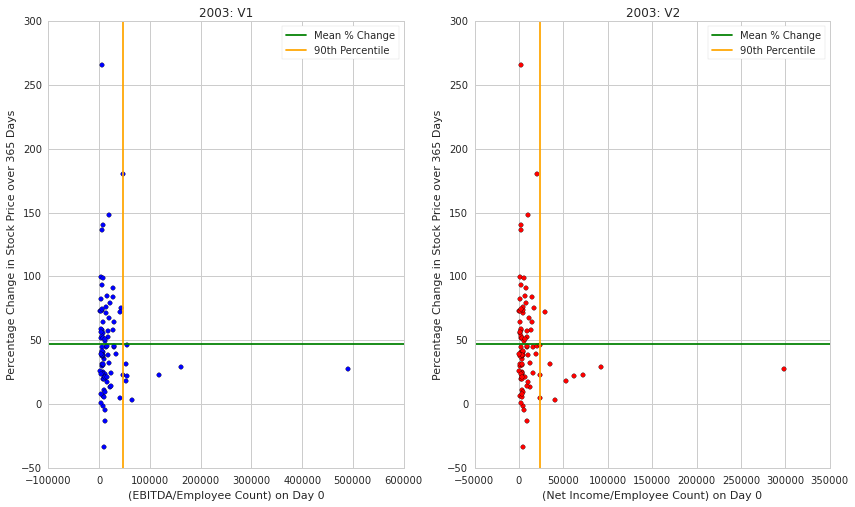

V1 Correlation:  (-0.076222092034244668, 0.46773141260462403)
V2 Correlation:  (-0.099007267404725, 0.34506709394530122)


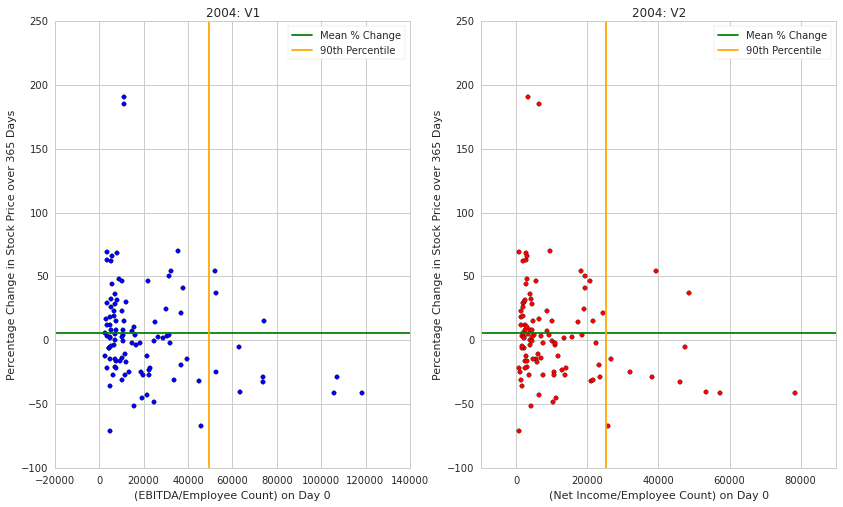

V1 Correlation:  (-0.24082616689519279, 0.013333629952411505)
V2 Correlation:  (-0.21172591444799743, 0.030142030639642332)


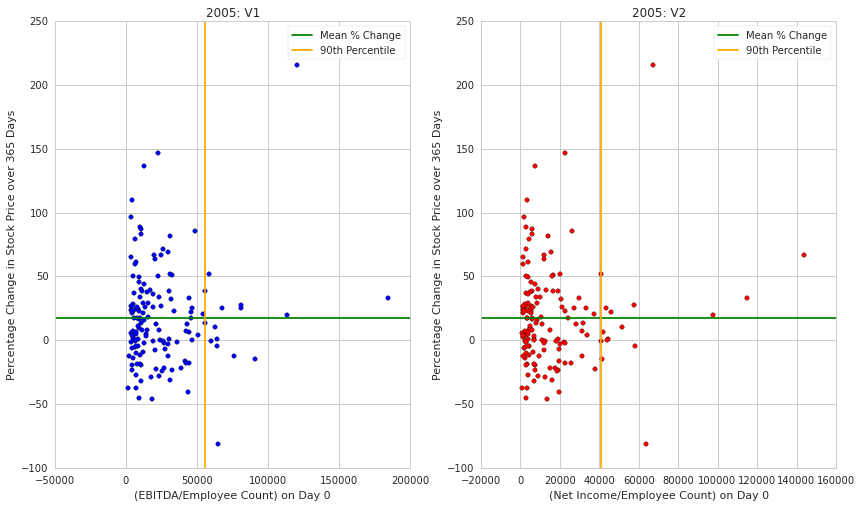

V1 Correlation:  (0.084329014631931362, 0.30325594293639518)
V2 Correlation:  (0.079052655861446067, 0.33461795760383783)


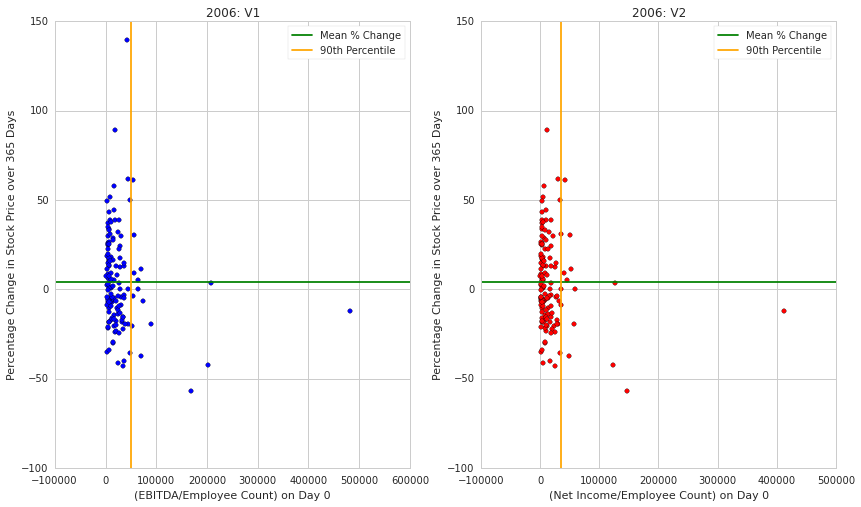

V1 Correlation:  (-0.16097330056391496, 0.055650356944899983)
V2 Correlation:  (0.179951492678465, 0.032117779008799592)


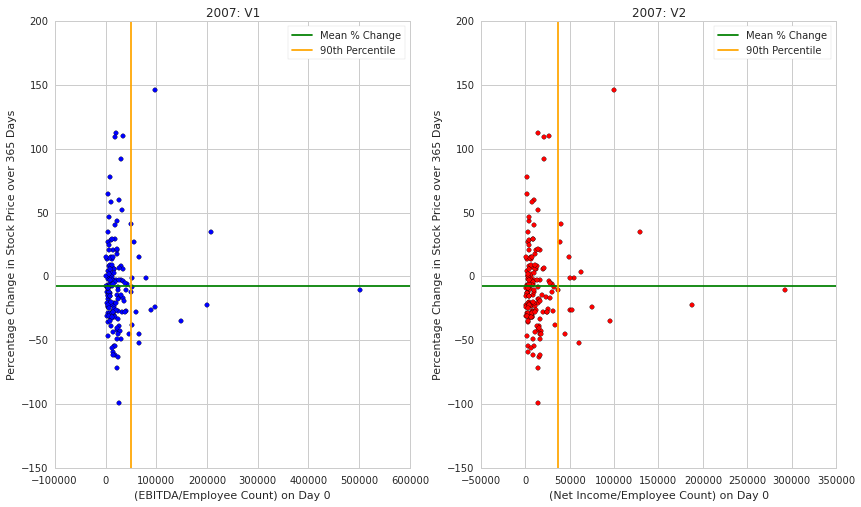

V1 Correlation:  (0.023430234087300363, 0.76797832551805056)
V2 Correlation:  (0.057091843572247947, 0.47192111841485096)


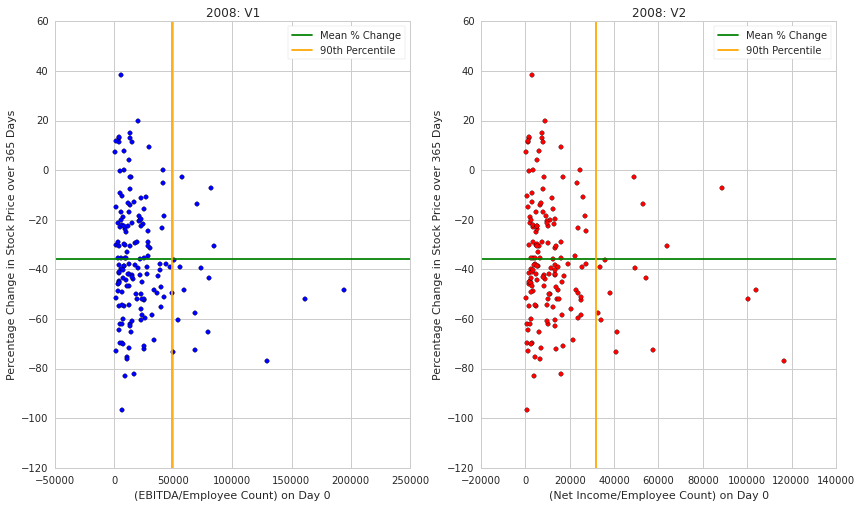

V1 Correlation:  (-0.1474273629173557, 0.060378915427558716)
V2 Correlation:  (-0.13705689856402417, 0.08105429021209215)


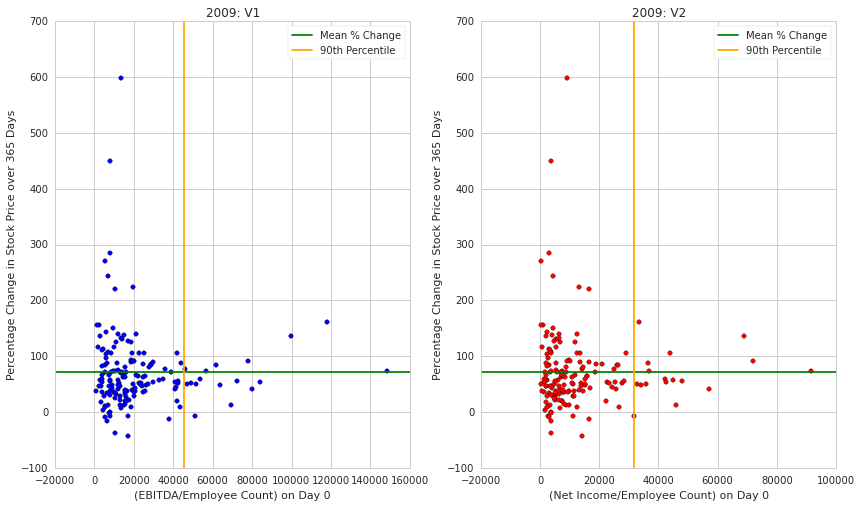

V1 Correlation:  (-0.037781736029093904, 0.63312734932786841)
V2 Correlation:  (-0.033045801194814921, 0.67634091561565191)


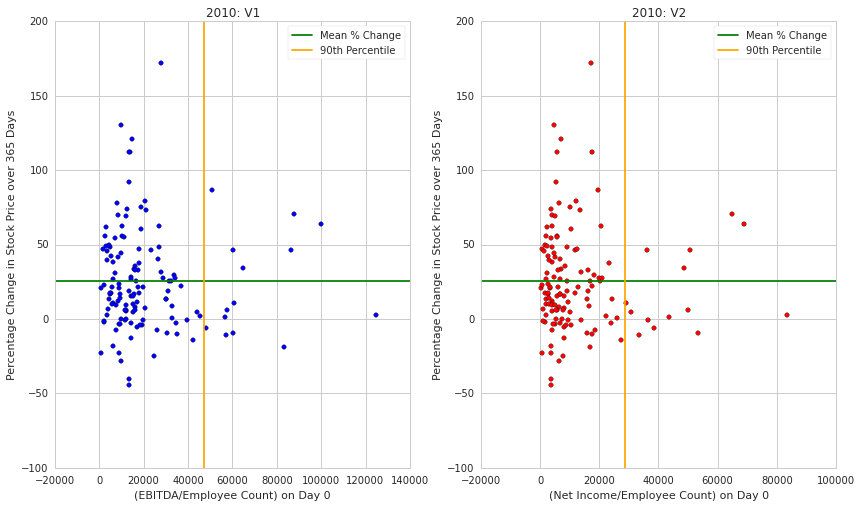

V1 Correlation:  (-0.040625884134787939, 0.64116880958631661)
V2 Correlation:  (-0.016445917251917248, 0.85040284515072351)


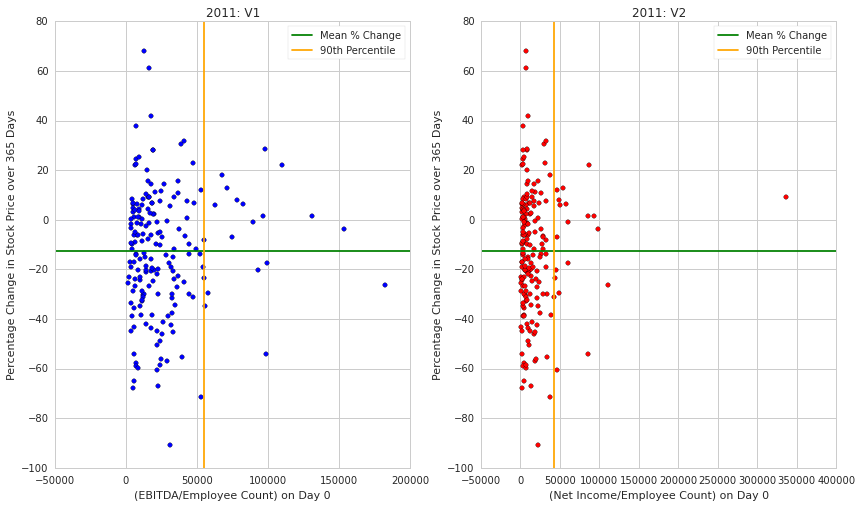

V1 Correlation:  (0.053939031503976671, 0.4622313023014446)
V2 Correlation:  (0.053301047929477208, 0.46755092671358078)


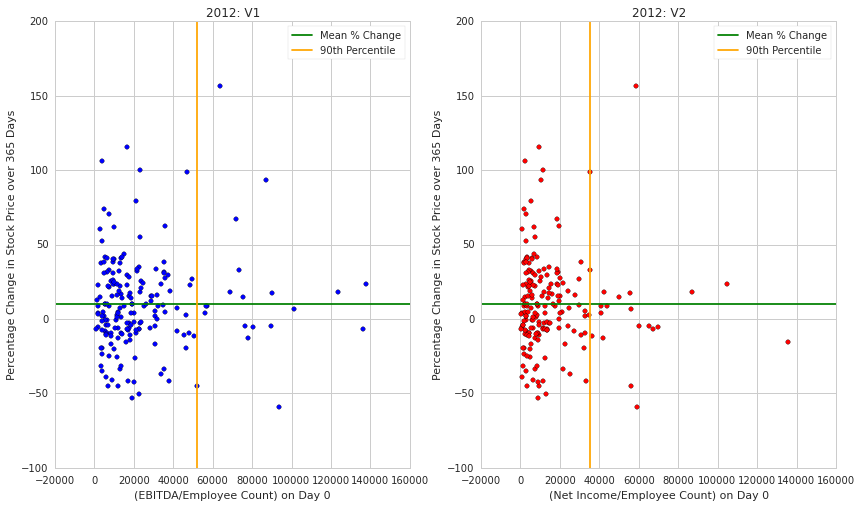

V1 Correlation:  (0.049112506621982369, 0.50100574270132336)
V2 Correlation:  (-0.043704486308273158, 0.54934922378802287)


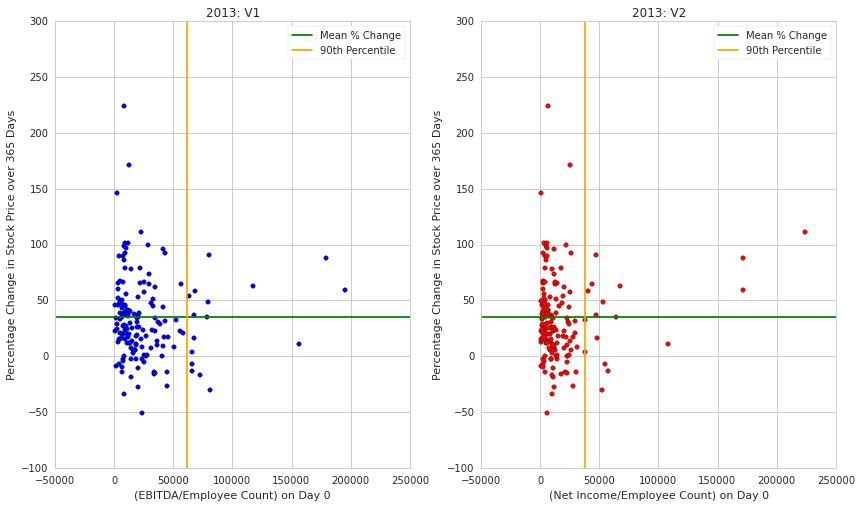

V1 Correlation:  (0.20127572531673857, 0.0097555458342217481)
V2 Correlation:  (0.29102375848860362, 0.00015646376875606146)


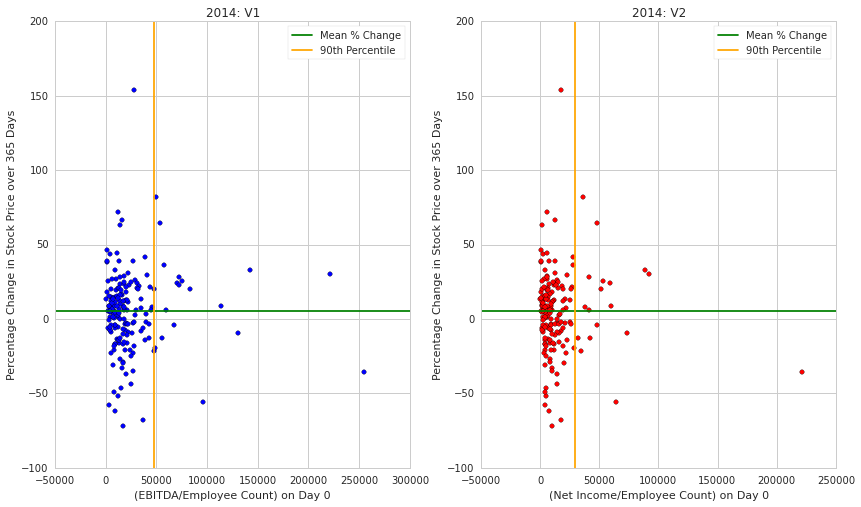

V1 Correlation:  (0.010104366611739237, 0.8932099935846961)
V2 Correlation:  (-0.026691794591659684, 0.72283440623895823)


In [25]:
# Now we've collected all the data points. Time to plot.
 
# We make two plots for each year -- one for V1, and one for V2. 
# We make these plots for each year separately so we can look 
# for particularly striking differences between years.
for i in range(13):
    year = years[i]

    dataThisYear = dataPointsByYear[year]
    # make lists of v1 scores, v2 scores, and percent change, so we can plot them!
    v1s = [v1 for (v1,v2,delta,sid) in dataThisYear]
    v2s = [v2 for (v1,v2,delta,sid) in dataThisYear]
    deltas = [delta for (v1,v2,delta,sid) in dataThisYear]
    deltaMean = np.mean(deltas)
    # calculate the 90th percentile
    v1pctile = np.percentile(v1s,90)
    v2pctile = np.percentile(v2s,90)
    
    # make the plot on the left (V1)
    plt.subplot(121)
    plt.scatter(v1s,deltas,c='blue')
    # add a line to show what the average percentage price change was
    plt.axhline(y=deltaMean, label='Mean % Change', color='green')
    # add a line to show what the 90th percentile in terms of V1 was
    plt.axvline(x=v1pctile, label='90th Percentile',color='orange')
    plt.legend(loc='upper right')
    plt.title(str(year)+": V1")
    plt.xlabel("(EBITDA/Employee Count) on Day 0")
    plt.ylabel("Percentage Change in Stock Price over 365 Days")

    # make the plot on the right (V2)
    plt.subplot(122)
    plt.scatter(v2s,deltas,c='red')
    # add a line on the plot to show what the average percentage price change was
    plt.axhline(y=deltaMean, label='Mean % Change', color='green')
    # add a line on the plot to show what the 90th percentile in terms of V1 was
    plt.axvline(x=v2pctile, label='90th Percentile',color='orange')
    plt.legend(loc='upper right')
    plt.title(str(year)+": V2")
    plt.xlabel("(Net Income/Employee Count) on Day 0")
    plt.ylabel("Percentage Change in Stock Price over 365 Days")
    
    # displays the two plots
    plt.show()

    # Going to use a Pearson Correlation Coefficient just to summarize.
    print "V1 Correlation: ", pearsonr(v1s, deltas)
    print "V2 Correlation: ", pearsonr(v2s, deltas)
    # notably, the output is (correlation coefficient, p-value)
    
# Clarification: what do the plots mean?    

# These are scatter plots. Every datapoint represents a stock (i.e. a company), that in that year had
# a certain V1 or V2 (on the x-axis) and a certain % change in stock price that year (on the y-axis).
# For example, on the 2002:V1 plot just below on the right, the red point closest to the top of the graph
# represents a company that had a V2 Score of about 3000 (i.e. had about $3000 in net income per employee).
# The green line, mean % change, just indicates what the average % change in stock price was that year. In
# the V2 graph below, it was about -25%. That's just so you can see more easily how companies performed
# compared to the average. The orange line denotes the 90th percentile of V1 or V2. That means that all
# datapoints to the right of the orange line were in the top 10% of companies by V1 or V2. In the V2 graph
# below, the 90th percentile was at about $20000 in net income per employee. That means that the top 10%
# of companies had at least $20000 in net income per employee. Again, that's just so you can identify
# the top 10% more easily and make visual judgements about them. 

# For example, looking at the V2 graph below on the right and using the orange line, we can count
# 7 companies in the top 10%. Using the green line, we can count that of those 7 companies, 5 of them
# performed under the average! 

# Important: Note the differing scales on the y-axes in the following plots.

### Plot Evaluation

The numerical results, i.e. the correlations, are generally close to zero. This implies weak correlations between V1 and Percentage Price Change, and between V2 and Percentage Price Change. These results suggest that my initial conjecture is erroneous. 

Beyond that, looking at the mean- and 90th-percentile plots suggest that the top 10% of employee-efficient tech companies in most years actually underperform. I also repeated all these plots for sector code 310 (industry), and with shorter time periods (180 days, 90 days). In both cases, I got results very similar to these. I also ended up testing the initial $\frac{\text{Market Cap}}{\text{Employee Count}}$ ratio, with similar results: it too is (as expected) not indicative of future stock performance.

Overall, these results suggest that the $V$ metric is not helpful in predicting future stock performance. In other words, it appears that the metrics we have constructed for measuring how efficiently companies use their employees are not viable as trading signals.

### Backtests

For some further evidence, we'll now run backtests on each one of the time periods: we'll compose a portfolio of the top 10% stocks by $V_1$ or $V_2$, with a uniform capital allocation to each position, and benchmark the result against SPY.

In [26]:
# Map every year to a list of the top 10% of stocks by V1, V2 for that year
topCompaniesV1 = {}
topCompaniesV2 = {}

for i in range(13):
    year = years[i]
    dataThisYear = dataPointsByYear[year]
    # make lists of v1 scores and v2 scores
    v1s = [v1 for (v1,v2,delta,sid) in dataThisYear]
    v2s = [v2 for (v1,v2,delta,sid) in dataThisYear]
    # compute 90th percentile
    v1pctile = np.percentile(v1s,90)
    v2pctile = np.percentile(v2s,90)
    # get the top 10% of stocks that year by v1, v2
    topv1s = [sid for (v1,v2,delta,sid) in dataThisYear if v1 >= v1pctile]
    topv2s = [sid for (v1,v2,delta,sid) in dataThisYear if v2 >= v2pctile]
    # map that year to the lists of top 10% stocks by v1, v2
    topCompaniesV1[year] = topv1s
    topCompaniesV2[year] = topv2s

### Running the Tests

As discussed above, I want to run (2 sets for every year, 13 years = 26) backtests. I originally planned to do this with `zipline` and run them all from the research notebook itself, but for various reasons, benchmarking and obtaining summary statistics (sharpe, beta, etc.) look as if they might raise some issues. Consequently, I decided to run all those backtests in the IDE instead, and then to import them into this notebook.

For the sake of completion, a copy of the IDE trading algorithm (commented out) is below:

In [27]:
"""
def initialize(context):
    # cash limit
    context.max = 1000000.0
    context.companies = COMPANIES
    context.dayCount = 0

# define buy-and-hold strategy
def handle_data(context,data):
    context.dayCount +=1
    if context.dayCount > 1:
        return
    cashPerCompany = context.max / len(context.companies)
    pricePerCompany = [data[x].price for x in context.companies]
    for i in range(len(context.companies)):
        order(context.companies[i], cashPerCompany/pricePerCompany[i])
"""

'\ndef initialize(context):\n    # cash limit\n    context.max = 1000000.0\n    context.companies = COMPANIES\n    context.dayCount = 0\n\n# define buy-and-hold strategy\ndef handle_data(context,data):\n    context.dayCount +=1\n    if context.dayCount > 1:\n        return\n    cashPerCompany = context.max / len(context.companies)\n    pricePerCompany = [data[x].price for x in context.companies]\n    for i in range(len(context.companies)):\n        order(context.companies[i], cashPerCompany/pricePerCompany[i])\n'

In [28]:
# cycle through all sets of top-performing companies for each year

# note: I have commented out all the print-statements in this section. The printed statements
# are not informative for reading, and they're an overwhelming wall of text.
# You'll need to uncomment them if you want to produce lists of stock ids to copy-paste into the IDE,
# if you want to run similar backtests yourself.

for i in range(len(years)):
    year = years[i]
    startDate = dates[i]
    endDate = addAYear(startDate)
    #print startDate, endDate
    for index,companyset in enumerate([topCompaniesV1,topCompaniesV2]):
        # printing the lists of stock ids so that I can easily copy-paste them into the IDE.
        #print year,"V"+str(index+1), "["+(",").join(["sid(" + str(x) + ")" for x in companyset[year]]) + "]"
        pass
    #print " "
        
# I then just copy-pasted the list of SIDs into the COMPANIES field in the algorithm, 
# as appropriate when running the backtests. 
# Also used the printed dates for every backtest, of course.

Having manually run all the backtests, I now grab all the results:

In [34]:
# IMPORTANT NOTE: Due to the mechanics of the Quantopian Platform, you will not be able to run this box.
# The reason is that it's referring to my private backtest IDs. Only I have access to these, and there's
# no way for me to make them public. However, though you can't run this cell, you can still see the results.
# Moreover, if you wish to repeat this experiment yourself, you can copy-paste in your own backtest IDs.
# It should be no problem for you to adapt this code.

res2002v1 = get_backtest('559ec570b56ce11240e70ad5')
res2002v2 = get_backtest('559ec956799f4c1244fc9518')

res2003v1 = get_backtest('559ec9d3871df51250296fd4')
res2003v2 = get_backtest('559eca0de48248124a9db7fe')

res2004v1 = get_backtest('559eca3c14c54b124cc46e35')
res2004v2 = get_backtest('559eca6f78389f1239b0f6ec')

res2005v1 = get_backtest('559ecaae78389f1239b0f6f7')
res2005v2 = get_backtest('559ecb0314c54b124cc46e5c')

res2006v1 = get_backtest('559ecb5214c54b124cc46e6e')
res2006v2 = get_backtest('559ecb97871df51250296fe9')

res2007v1 = get_backtest('559ecbdd14c54b124cc46e8f')
res2007v2 = get_backtest('559ecc114c08da125abd5d39')

res2008v1 = get_backtest('559ecc5514c54b124cc46eaf')
res2008v2 = get_backtest('559eccd9871df51250296ff8')

res2009v1 = get_backtest('559ecd3bb56ce11240e70b28')
res2009v2 = get_backtest('559ecd91799f4c1244fc954b')

res2010v1 = get_backtest('559ecdf048d3461247e5fb49')
res2010v2 = get_backtest('559ece12e48248124a9db827')

res2011v1 = get_backtest('559ece5678389f1239b0f73b')
res2011v2 = get_backtest('559ece7678389f1239b0f740')

res2012v1 = get_backtest('559eceb248d3461247e5fb6e')
res2012v2 = get_backtest("559ecee2b56ce11240e70b4c")

res2013v1 = get_backtest('559ecf14871df51250297022')
res2013v2 = get_backtest('559ecf4848d3461247e5fb7d')

res2014v1 = get_backtest('559ecf7a871df51250297043')
res2014v2 = get_backtest("559ecf98871df5125029704a")

100% Time: 0:00:01|###########################################################|
100% Time: 0:00:01|###########################################################|
100% Time: 0:00:01|###########################################################|
100% Time: 0:00:01|###########################################################|
100% Time: 0:00:01|###########################################################|
100% Time: 0:00:01|###########################################################|
100% Time: 0:00:01|###########################################################|
100% Time: 0:00:01|###########################################################|
100% Time: 0:00:01|###########################################################|
100% Time: 0:00:01|###########################################################|
100% Time: 0:00:01|###########################################################|
100% Time: 0:00:01|###########################################################|
100% Time: 0:00:01|#####################

It is tempting to make timeseries visualizations of the backtests themselves, but that's unlikely to be helpful. The following summary data says enough on its own.

In [30]:
# organizing the results
results = [(res2002v1, "2002v1"), (res2002v2, "2002v2"), (res2003v1, "2003v1"), (res2003v2, "2003v2"),
           (res2004v1, "2004v1"), (res2004v2, "2004v2"), (res2005v1, "2005v1"), (res2005v2, "2005v2"),
           (res2006v1, "2006v1"), (res2006v2, "2006v2"), (res2007v1, "2007v1"), (res2007v2, "2007v2"), 
           (res2008v1, "2008v1"), (res2008v2, "2008v2"), (res2009v1, "2009v1"), (res2009v2, "2009v2"),
           (res2010v1, "2010v1"), (res2010v2, "2010v2"), (res2011v1, "2011v1"), (res2011v2, "2011v2"), 
           (res2012v1, "2012v1"), (res2012v2, "2012v2"), (res2013v1, "2013v1"), (res2013v2, "2013v2"),
           (res2014v1, "2014v1"), (res2014v2, "2014v2")]

v1res = [(a,b) for (a,b) in results if "v1" in b]
v2res = [(a,b) for (a,b) in results if "v2" in b]

In [31]:
# making specific lists of result types
v1returns = []
v1alpha = []
v1beta = []
v1sharpes = []

v2returns = []
v2alpha = []
v2beta = []
v2sharpes = []

def sformat(returns,alpha,beta,sharpe):
    # to format result-strings for readability
    a = '{0: >6}'.format("%0.3f" % returns)
    b = '{0: >6}'.format("%0.3f" % alpha)
    c = '{0: >6}'.format("%0.3f" % beta)
    d = '{0: >6}'.format("%0.3f" % sharpe)
    return a,b,c,d

def getstats(res):
    # to get relevant statistics about the backtest
    returns = res.cumulative_performance.returns[-1]
    alpha = res.risk.alpha[-1]
    beta = res.risk.beta[-1]
    sharpe = res.risk.sharpe[-1]
    return returns,alpha,beta,sharpe

In [35]:
# I planned to include drawdown in the summary stats, but couldn't find a convenient method for doing it,
# so I'll just go without it for now.

# This code will print a summary table of results.

for (res,title) in v1res:
    returns,alpha,beta,sharpe = getstats(res)
    v1returns.append(returns)
    v1alpha.append(alpha)
    v1beta.append(beta)
    v1sharpes.append(sharpe)
    streturn, stralpha, strbeta, strarpe = sformat(returns,alpha,beta,sharpe)
    print title, "   returns:", streturn, "   alpha:", '%5s' % stralpha, "   beta:", '%5s' % strbeta, "   sharpe:", '%5s' % strarpe 
print "\nv1: Mean Return:", "%0.3f" % np.mean(v1returns), "   Mean Alpha:", "%0.3f" % np.mean(v1alpha), "   Mean Beta:", "%0.3f" % np.mean(v1beta), "   Mean Sharpe:", "%0.3f" % np.mean(v1sharpes)
print " "

for (res,title) in v2res:
    returns,alpha,beta,sharpe = getstats(res)
    v2returns.append(returns)
    v2alpha.append(alpha)
    v2beta.append(beta)
    v2sharpes.append(sharpe)
    streturn, stralpha, strbeta, strarpe = sformat(returns,alpha,beta,sharpe)
    print title, "   returns:", streturn, "   alpha:", '%5s' % stralpha, "   beta:", '%5s' % strbeta, "   sharpe:", '%5s' % strarpe 
print "\nv2: Mean Return:", "%0.3f" % np.mean(v2returns), "   Mean Alpha:", "%0.3f" % np.mean(v2alpha), "   Mean Beta:", "%0.3f" % np.mean(v2beta), "   Mean Sharpe:", "%0.3f" % np.mean(v2sharpes)

2002v1    returns: -0.446    alpha: -0.130    beta:  1.413    sharpe: -1.050
2003v1    returns:  0.383    alpha:  0.078    beta:  1.373    sharpe:  1.116
2004v1    returns: -0.120    alpha: -0.222    beta:  1.679    sharpe: -0.620
2005v1    returns:  0.217    alpha:  0.113    beta:  1.166    sharpe:  0.932
2006v1    returns: -0.053    alpha: -0.201    beta:  1.505    sharpe: -0.512
2007v1    returns: -0.016    alpha: -0.007    beta:  1.176    sharpe: -0.241
2008v1    returns: -0.438    alpha: -0.067    beta:  1.061    sharpe: -0.987
2009v1    returns:  0.640    alpha:  0.370    beta:  0.964    sharpe:  2.048
2010v1    returns:  0.245    alpha:  0.115    beta:  1.070    sharpe:  0.960
2011v1    returns: -0.032    alpha: -0.063    beta:  1.121    sharpe: -0.179
2012v1    returns:  0.210    alpha:  0.022    beta:  1.269    sharpe:  0.984
2013v1    returns:  0.460    alpha:  0.164    beta:  1.114    sharpe:  2.606
2014v1    returns:  0.159    alpha:  0.024    beta:  1.309    sharpe:  0.756

### Backtest Evaluation

It is apparent from the numerical results in the table that both strategies generally result in low returns and low alpha, which are undesirable. Further, both strategies are high-beta, i.e. quite strongly market-tracking, which is also undesirable. To boot, the sharpe is generally weak as well. These results give further evidence to our earlier conclusion that **neither $V_1$ nor $V_2$ is, in this current state, viable as a buy signal**. 

Finally, we will test the correlations between these results for $V_1$ and $V_2$:

In [33]:
# recall that correlations are expressed in the form of (correlation coefficient, p-value)

print "V1 and V2 Returns Correlation:", pearsonr(v1returns,v2returns)
print "V1 and V2 Alpha Correlation:", pearsonr(v1alpha,v2alpha)
print "V1 and V2 Beta Correlation:", pearsonr(v1beta,v2beta)
print "V1 and V2 Sharpe Correlation:", pearsonr(v1sharpes, v2sharpes)

V1 and V2 Returns Correlation: (0.97788289176719456, 8.0295636343967768e-09)
V1 and V2 Alpha Correlation: (0.93165879821940312, 3.6353020018937067e-06)
V1 and V2 Beta Correlation: (0.96338219824961524, 1.2498739678459528e-07)
V1 and V2 Sharpe Correlation: (0.96357674601833554, 1.2142412583005337e-07)


### Conclusion

The correlations between $V_1$ and $V_2$ in these four key measurements are extremely strong. These numerical results are also commensurate with the visual similarity between the scatter plots for each year earlier in the project. We can effectively conclude that $V_1$ and $V_2$ are the same strategy. This is not particularly surprising, since `ebitda` and `net_income` are fundamentally similar.

**We have to conclude that neither $V_1$ nor $V_2$ is a viable trading signal *at all***. This is a somewhat surprising result, but it has an interesting corollary: it suggests that the much-despised administrative and managerial bloat that drives up employee numbers may not be so damaging (at least in terms of stock price) after all. But that suggestion has to be investigated further before we can jump to any conclusions.

Finally, it is possible that a viable buy-signal could be constructed using the ideas discussed in this investigation, but it would have to compose the metric $V$ differently. It is also possible that more favorable correlations or interesting results could be found on a multi-year timescale rather than on one-year intervals, but this is an investigation for another time.